In [1]:
%load_ext autoreload

In [2]:
import os
os.chdir("../")

In [8]:
%autoreload 2
from pathlib import Path

import torch
import numpy as np
import ot as pot
from matplotlib import pyplot as plt

from sb.nn import SimpleNet
from sb.samplers import utils
from sb.data.datasets import MixOfGaussians, SCurve, TwoMoons

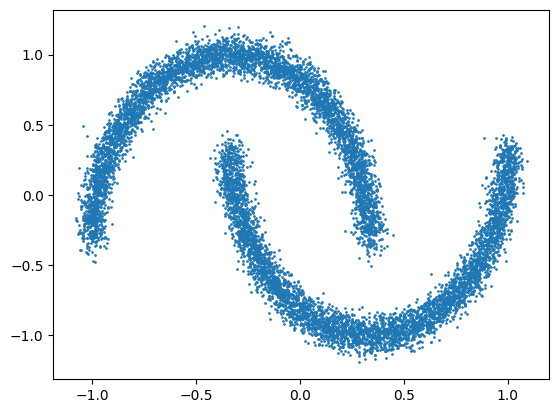

In [11]:
d = TwoMoons(None, noise=0.05)
plt.scatter(*d.sample(10_000).T, s=0.9)
plt.show()

In [ ]:
def retrieve_checkpoint_by_id(wandb_id, search_path=Path('./wandb')):
    folder = [*search_path.glob(f"*{wandb_id}*")][0]
    ckpt = folder / "files" / "checkpoints" / "checkpoint-final.pth"
    return ckpt.as_posix()

In [59]:
wandb_id = "1dqchhgl"
ckpt_path = retrieve_checkpoint_by_id(wandb_id)
ckpt = torch.load(ckpt_path, weights_only=True)

In [61]:
fwd_model = SimpleNet(
    t_emb_size=64,
    x_emb_size=64,
    in_dim=2,
    out_dim=2,
    n_main_body_layers=3,
    # predict_log_var=True,
)
fwd_model.load_state_dict(ckpt['forward'])
fwd_model.eval().to('cuda:1')
None

In [62]:
dt = 0.004
t_max = 0.08
num_steps = 20
matching_method = 'mean' # ll, mean, score
xt_m_dt = torch.randn(10_000, 2, device='cuda:1') * 0.7

for t_step in torch.linspace(dt, t_max, num_steps):
    t = torch.ones(xt_m_dt.size(0), device=xt_m_dt.device) * t_step

    with torch.no_grad():
        fwd_out, fwd_log_var = utils.get_mean_log_var(
            fwd_model, xt_m_dt, t - dt, dt
        )
        noise_std = fwd_log_var.exp().sqrt()

    if matching_method == "ll":
        xt = fwd_out + torch.randn_like(fwd_out) * noise_std
    
    elif matching_method == "mean":
        xt = fwd_out + torch.randn_like(fwd_out) * noise_std

    elif matching_method == "score":
        xt = xt_m_dt + fwd_out + torch.randn_like(fwd_out) * noise_std

    xt_m_dt = xt

In [63]:
p1_true = MixOfGaussians(
     means=[[1.0, 0.0], [0.7, 0.7], [0.0, 1.0], [-0.7, 0.7], [-1.0, 0.0], [-0.7, -0.7], [0.0, -1.0], [0.7, -0.7]],
    sigmas=[[0.1, 0.1], [0.1, 0.1], [0.1, 0.1], [0.1, 0.1], [0.1, 0.1], [0.1, 0.1], [0.1, 0.1], [0.1, 0.1]]
)

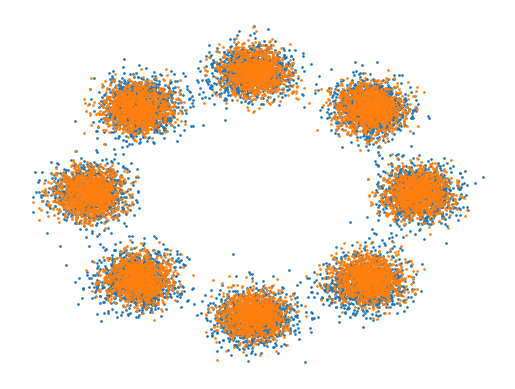

In [64]:
plt.scatter(*xt_m_dt.cpu().T, s=0.9)
plt.scatter(*p1_true.sample(10_000).T, s=0.9)
plt.axis('off')
plt.show()


In [66]:
def compute_w2_distance(true, pred, reg=1.0):
    cost_matrix = pot.dist(true, pred, metric='euclidean') ** 2
    a = torch.ones(true.shape[0], device=true.device) / true.shape[0]
    b = torch.ones(pred.shape[0], device=pred.device) / pred.shape[0]
    w2_distance = pot.sinkhorn2(a, b, cost_matrix, reg)
    return w2_distance


w2 = compute_w2_distance(xt_m_dt.cpu(), p1_true.sample(10_000))
print(f"W2 {np.sqrt(w2):.2f}")

W2 0.79


/tmp/ipykernel_1843796/3268319079.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"W2 {np.sqrt(w2):.2f}")
